In [21]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate,Input 
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt

In [22]:
os.environ ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
batch_size=16
Lr=0.0001
epochs=120
height=64
width=64

In [24]:
dataset_path= os.path.join("dataset")
files_dir=os.path.join("files")

In [25]:
def conv_block(inputs, num_filters):
    x=Conv2D(num_filters, 3, padding="same")(inputs)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)

    x=Conv2D(num_filters, 3, padding="same")(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    return x

In [26]:
def encoder_block(inputs, num_filters):
    x=conv_block(inputs, num_filters)
    p=MaxPool2D((2, 2))(x)
    return x,p

In [27]:
def decoder_block(inputs, skip, num_filters):
    x=UpSampling2D((2, 2))(inputs)
    x=Concatenate()([x,skip])
    x=conv_block(x,num_filters)
    return x

In [28]:
def build_unet(input_shape):
    inputs=Input(input_shape)
    s1,p1=encoder_block(inputs,32)
    s2,p2=encoder_block(p1,64)
    s3,p3=encoder_block(p2,128)
    b1=conv_block(p3,256)
    d1=decoder_block(b1,s3,128)
    d2=decoder_block(d1,s2,64)
    d3=decoder_block(d2,s1,32)
    outputs=Conv2D(1,1,padding="same",activation="sigmoid")(d3)
    model=Model(inputs,outputs,name="UNET")
    return model

In [29]:
def load_data(path):
    train_x=sorted(glob(os.path.join(path,"train","images","*")))
    train_y=sorted(glob(os.path.join(path,"train","masks","*")))
    valid_x=sorted(glob(os.path.join(path,"valid","images","*")))
    valid_y=sorted(glob(os.path.join(path,"valid","masks","*")))
    return (train_x,train_y),(valid_x,valid_y)

In [30]:
def read_image(path):
    x=cv2.imread(path, cv2.IMREAD_COLOR)
    x=x/255.0
    return x

In [31]:
def read_mask(path):
    x= cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x=x/255.0
    x=np.expand_dims(x,axis=-1)
    return x

In [32]:
(train_x,train_y),(valid_x,valid_y)=load_data(dataset_path)

In [33]:
train_data_x=np.zeros((len(train_x),width,height,3),dtype='float')
train_data_y=np.zeros((len(train_y),width,height,1),dtype='float')
valid_data_x=np.zeros((len(valid_x),width,height,3),dtype='float')
valid_data_y=np.zeros((len(valid_y),width,height,1),dtype='float')

In [34]:
for i in range(len(train_x)):
    train_data_x[i]=read_image(train_x[i])
    train_data_y[i]=read_mask(train_y[i])
    
for i in range(len(valid_x)):
    valid_data_x[i]=read_image(valid_x[i])
    valid_data_y[i]=read_mask(valid_y[i])

In [35]:
input_shape=(height,width,3)
model=build_unet(input_shape)

In [36]:
model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(Lr),metrics=["acc"])

In [37]:
callbacks=[
    ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4),
    EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=False)
]

In [38]:
model.fit(
    train_data_x,
    train_data_y,
    batch_size=batch_size,
    validation_data=(valid_data_x,valid_data_y),
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - acc: 0.7654 - loss: 0.4029 - val_acc: 0.7957 - val_loss: 0.6788 - learning_rate: 1.0000e-04
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.8044 - loss: 0.2968 - val_acc: 0.7958 - val_loss: 0.6522 - learning_rate: 1.0000e-04
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.8160 - loss: 0.2553 - val_acc: 0.7958 - val_loss: 0.6068 - learning_rate: 1.0000e-04
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.8214 - loss: 0.2286 - val_acc: 0.7958 - val_loss: 0.5588 - learning_rate: 1.0000e-04
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.8252 - loss: 0.2080 - val_acc: 0.7959 - val_loss: 0.5260 - learning_rate: 1.0000e-04
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 949ms/step - acc: 0.8275 - loss: 0.1911 - val_acc: 0.7959 - val_loss: 0.4927 - learning_rate: 1.0000e-04
Epoch 7/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 637ms/step - acc: 0.8293 - loss: 0.1777 - val_acc: 0.7959 - val_loss: 0.4636 - lear

In [39]:
y_predict=model.predict(valid_data_x)

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step


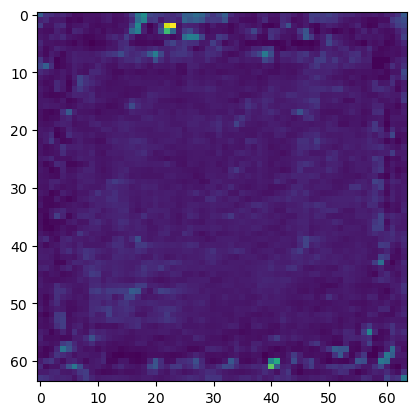

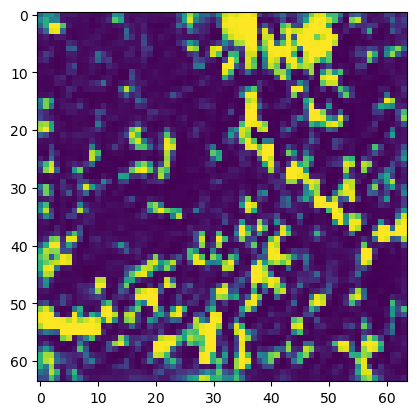

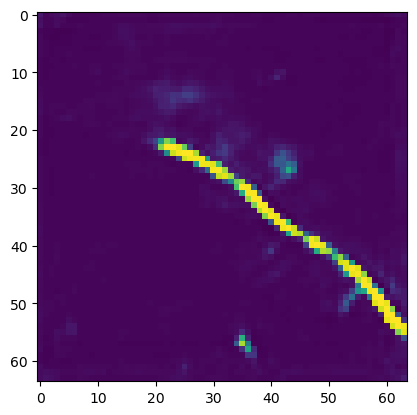

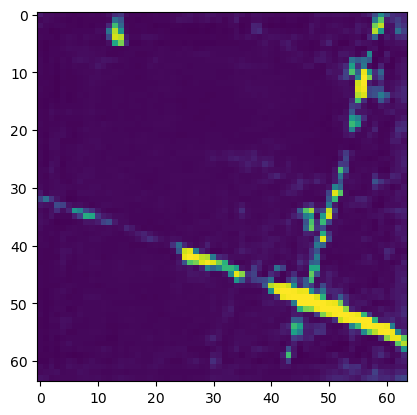

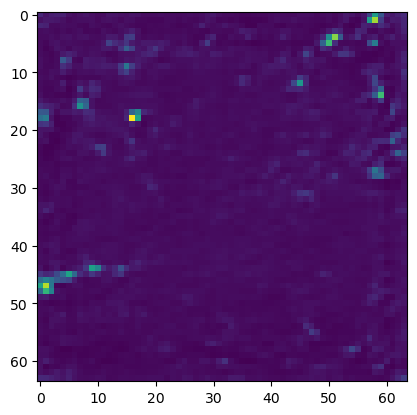

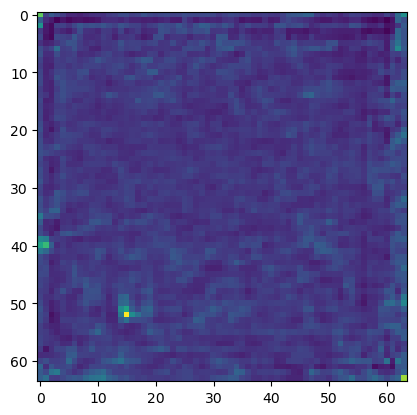

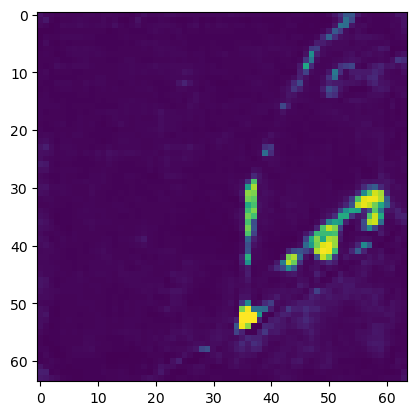

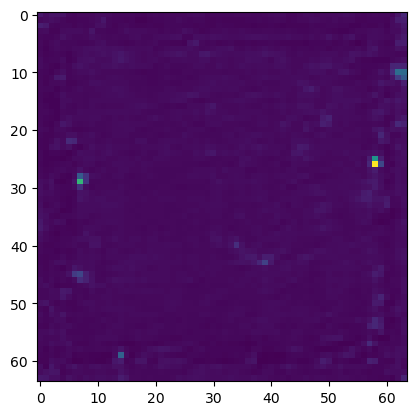

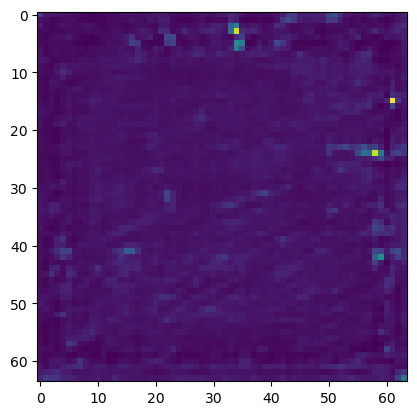

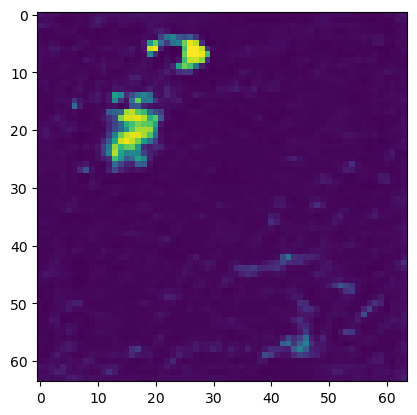

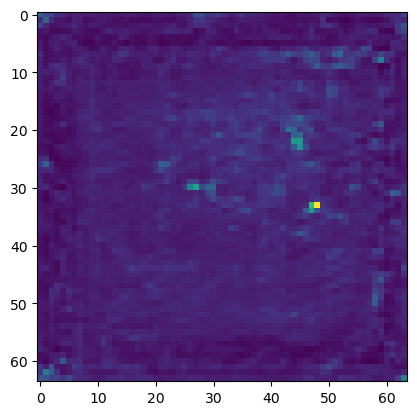

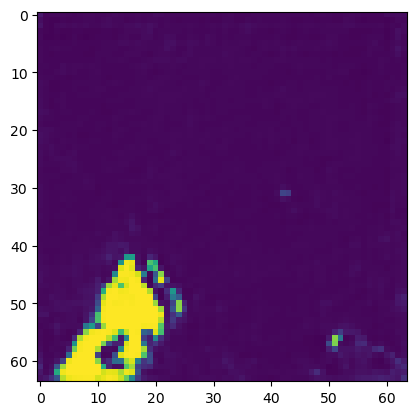

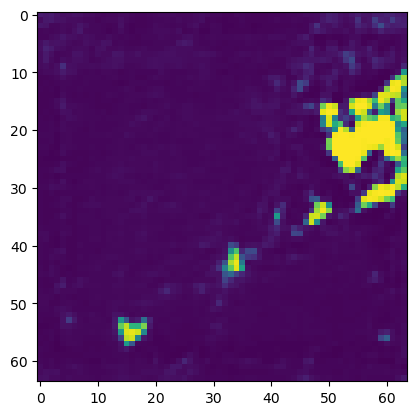

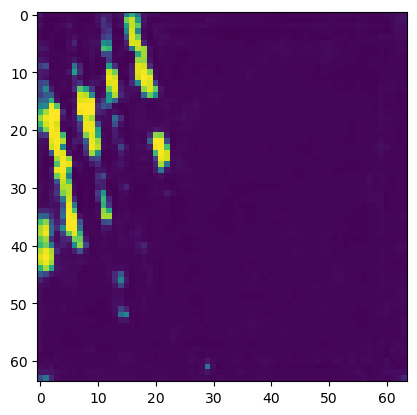

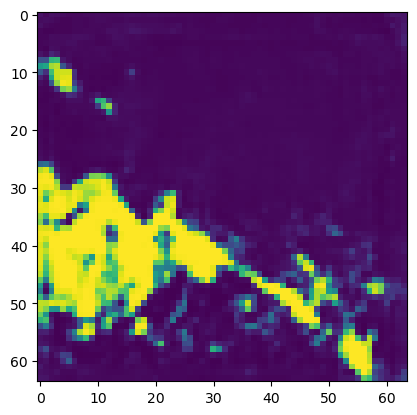

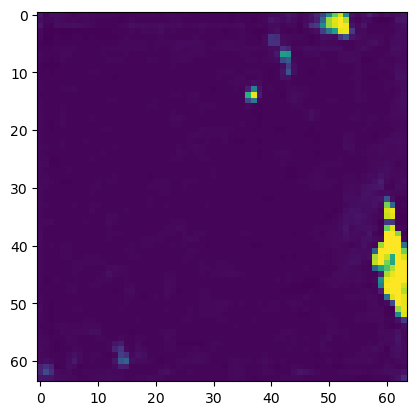

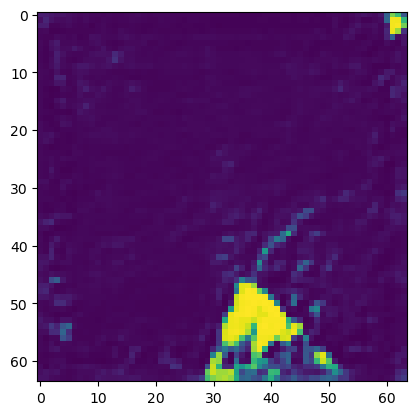

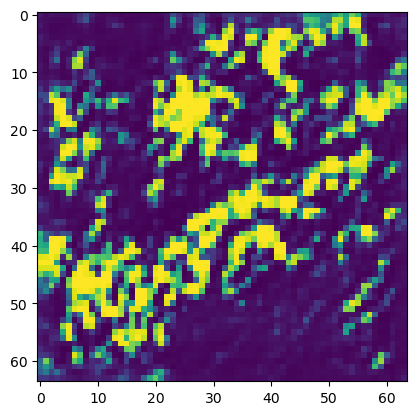

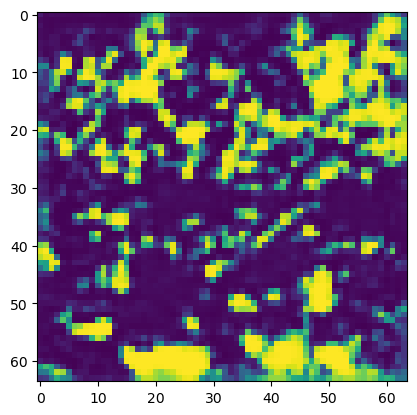

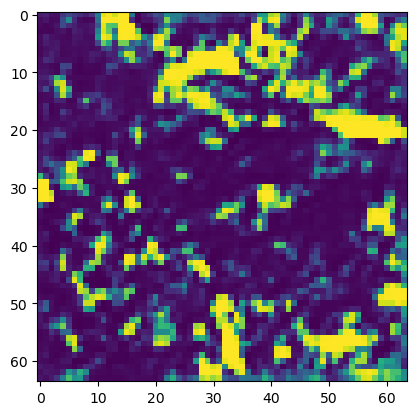

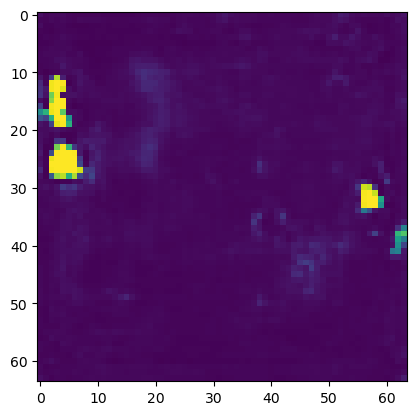

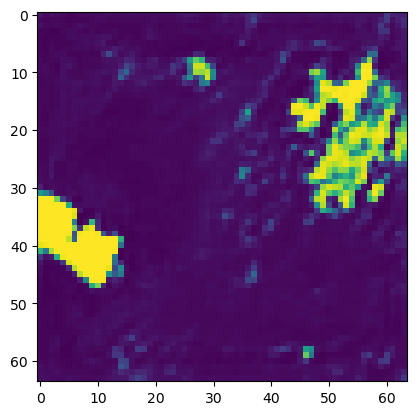

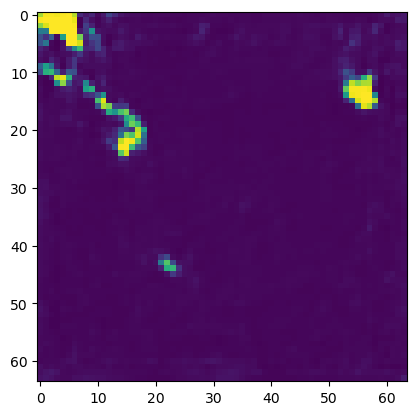

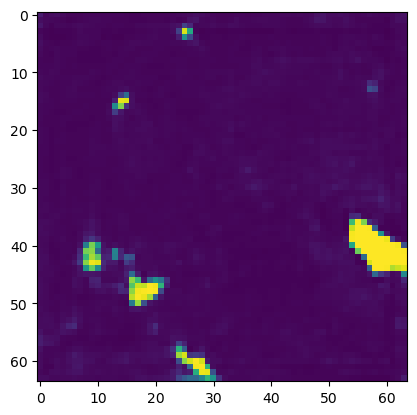

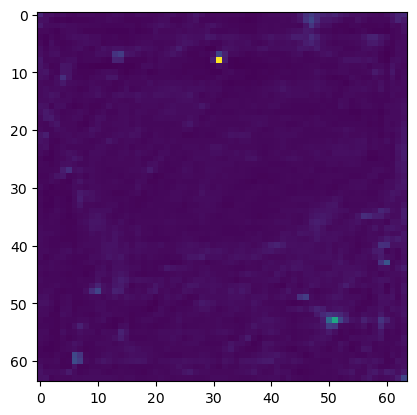

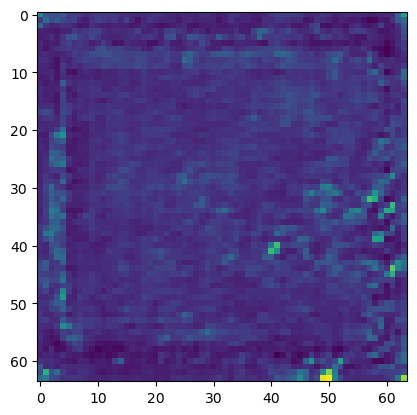

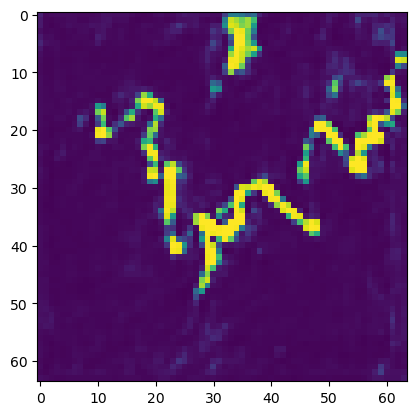

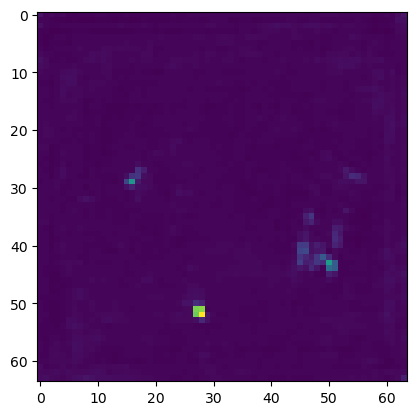

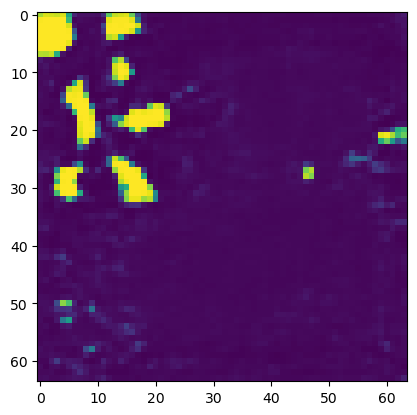

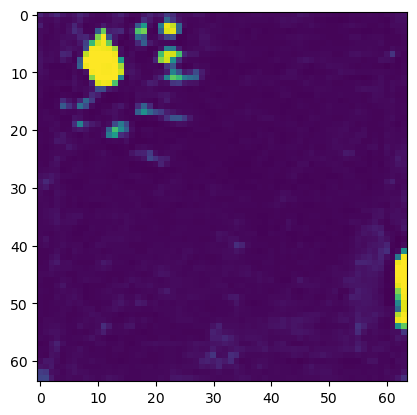

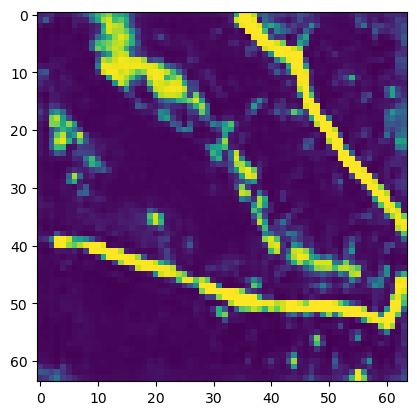

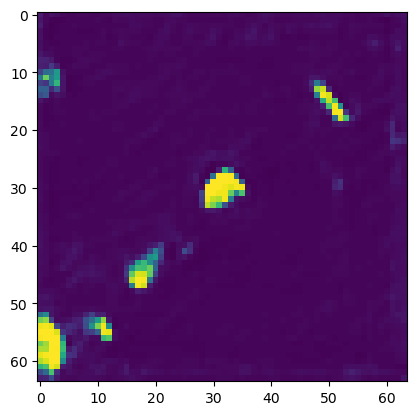

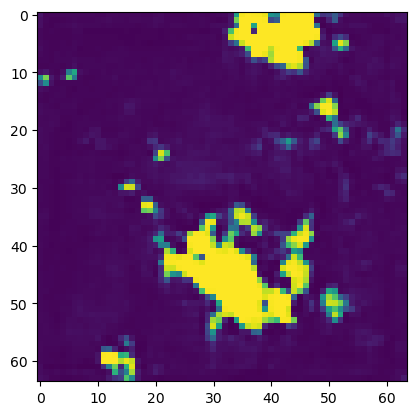

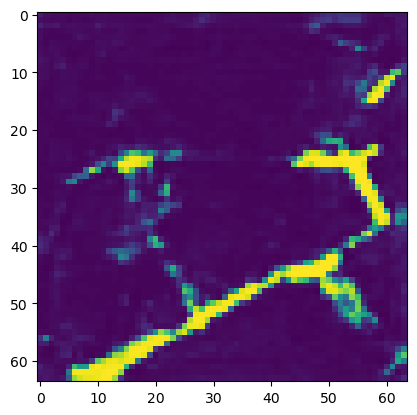

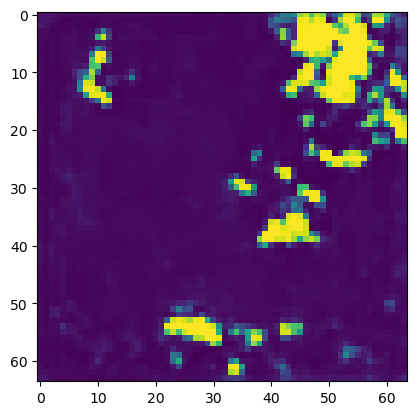

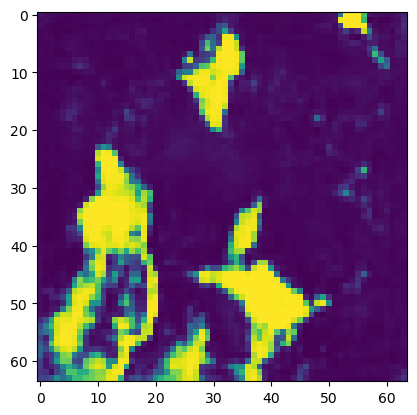

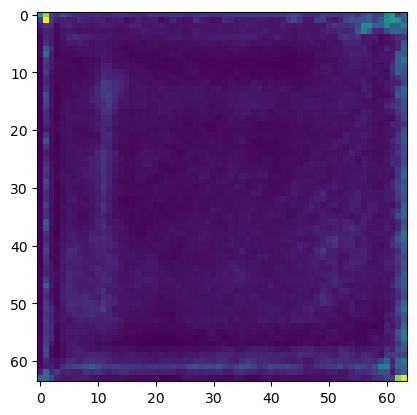

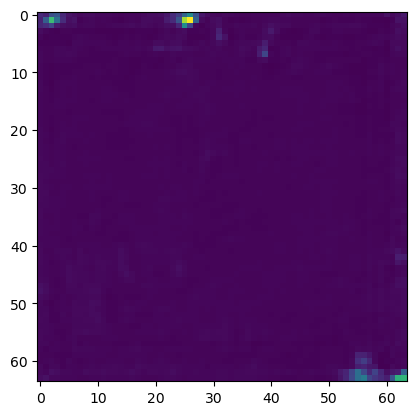

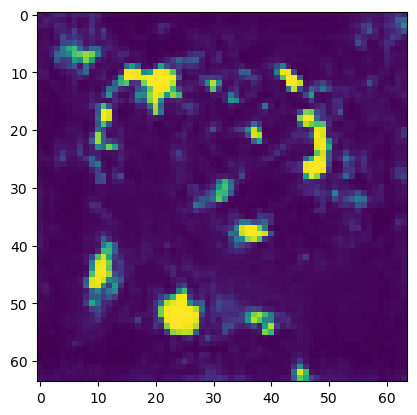

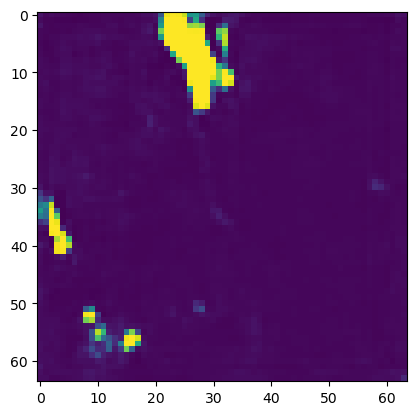

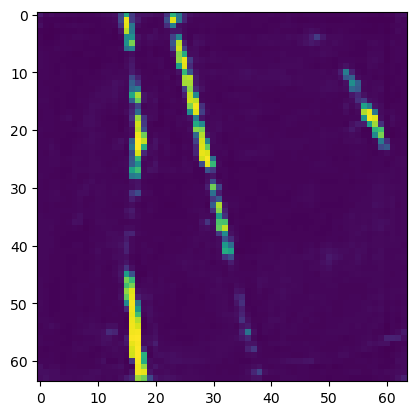

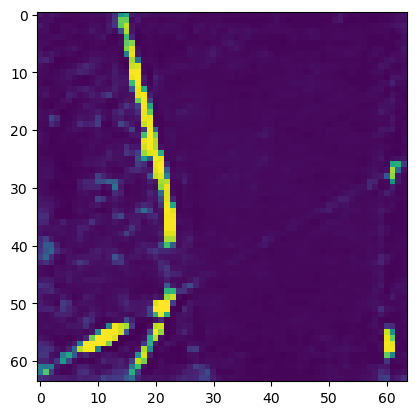

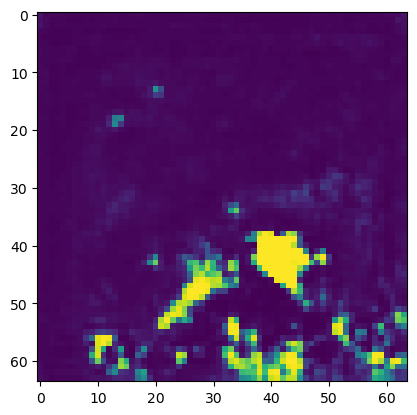

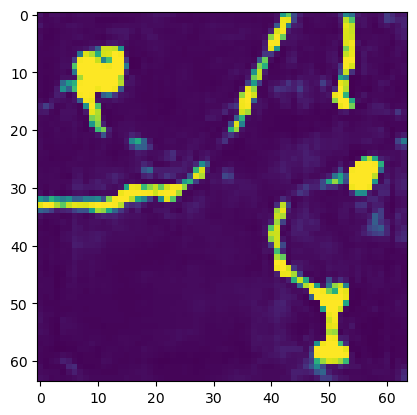

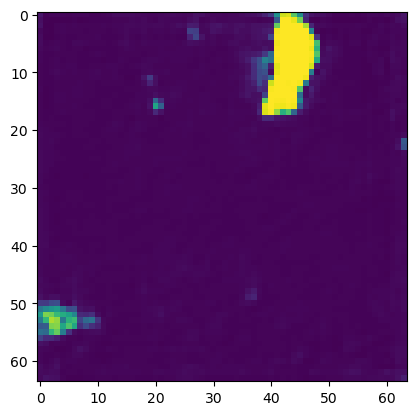

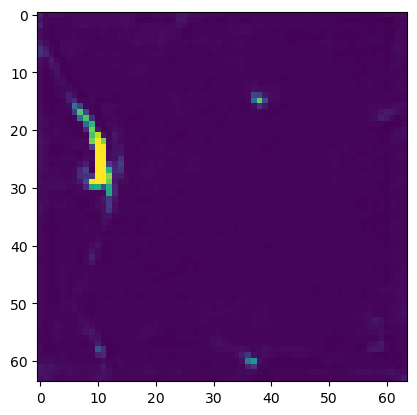

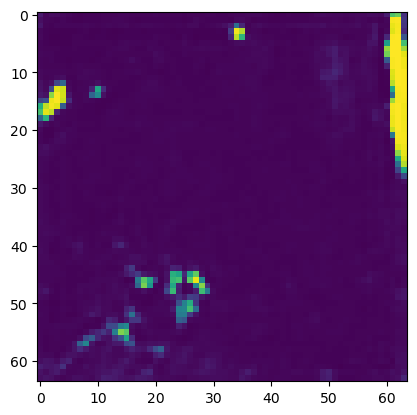

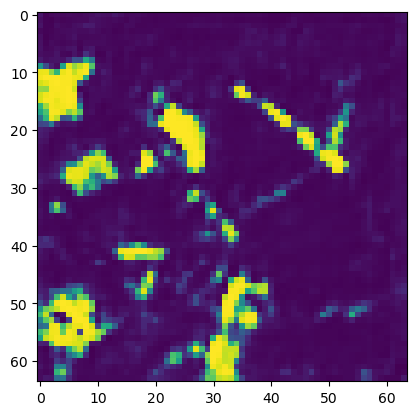

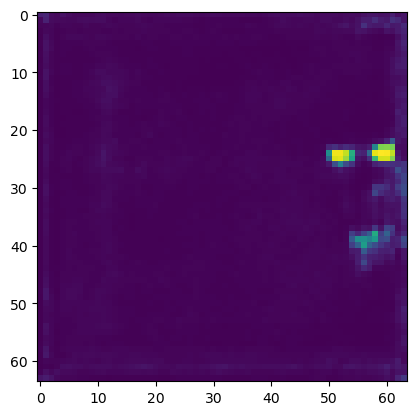

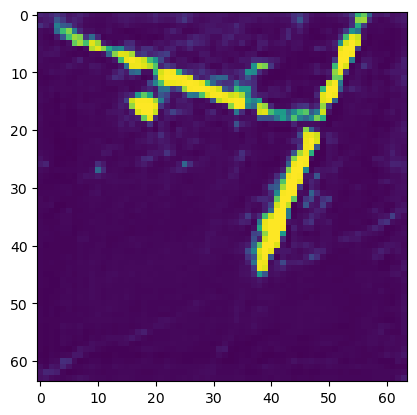

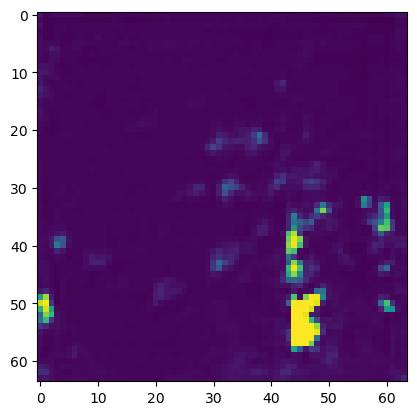

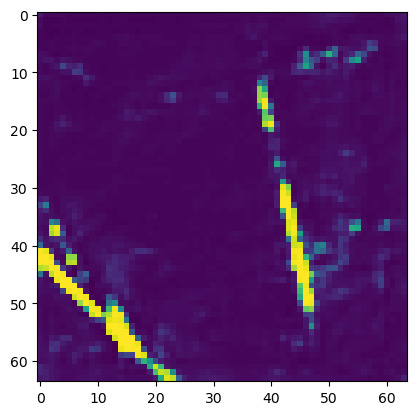

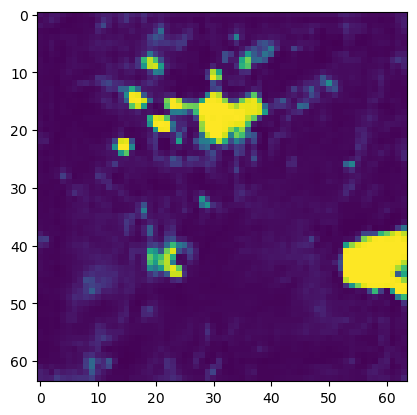

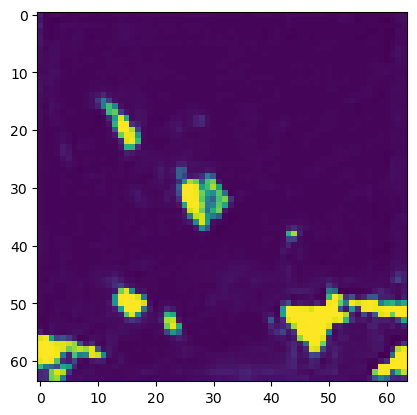

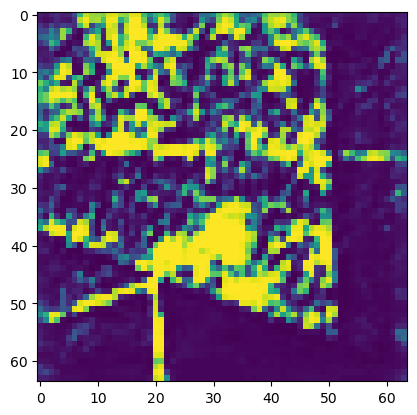

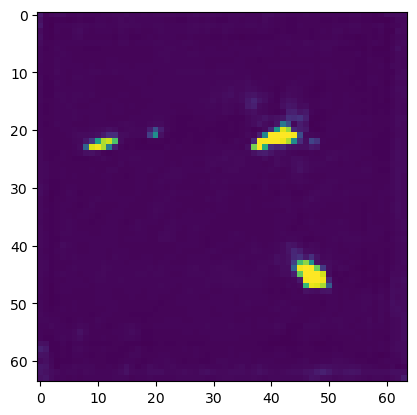

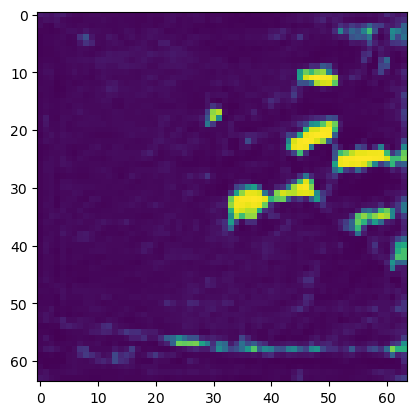

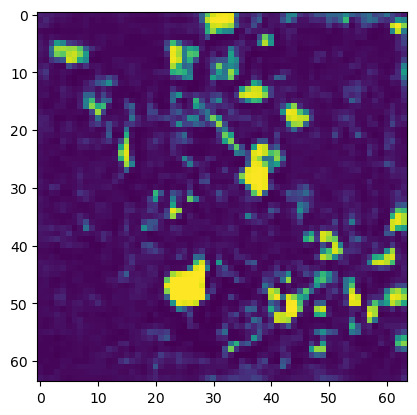

In [40]:
for i in range(y_predict.shape[0]):
    plt.imshow(y_predict[i])
    plt.show()

In [48]:
test_x=sorted(glob(os.path.join(dataset_path,"test","images","*")))

In [49]:
test_data_x=np.zeros((len(test_x),width,height,3),dtype='float')

In [50]:
for i in range(len(test_x)):
    test_data_x[i]=read_image(test_x[i])

In [51]:
test_predict=model.predict(test_data_x)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


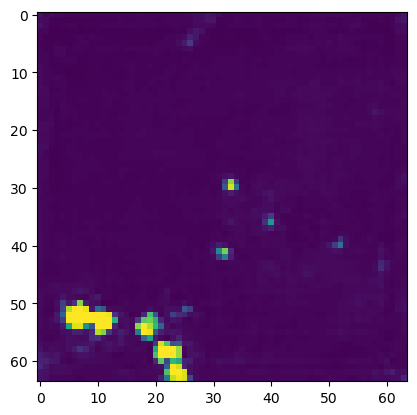

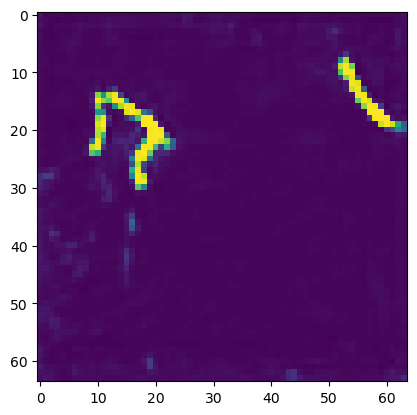

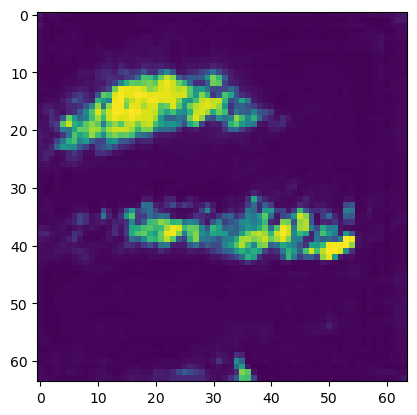

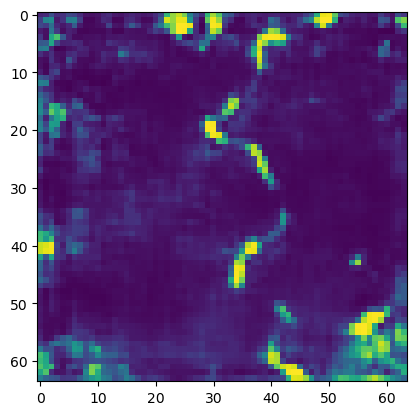

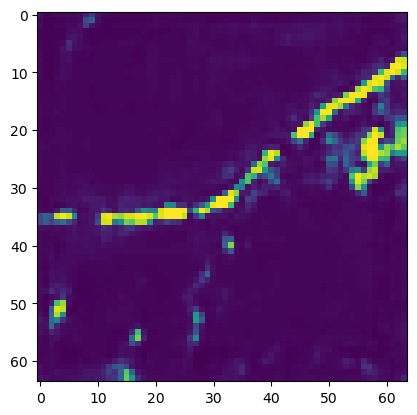

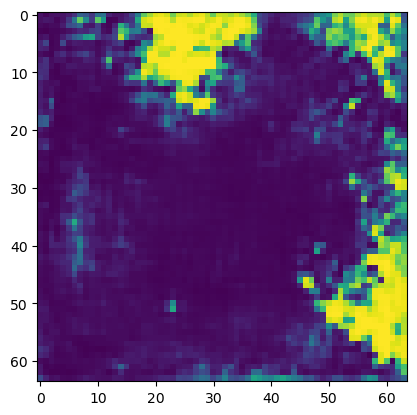

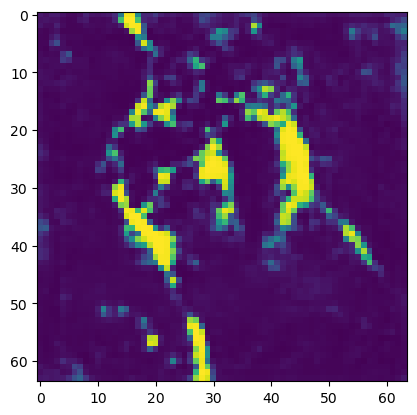

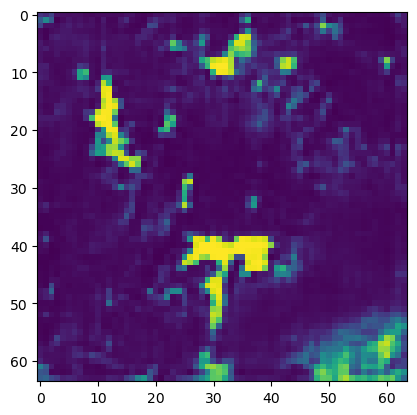

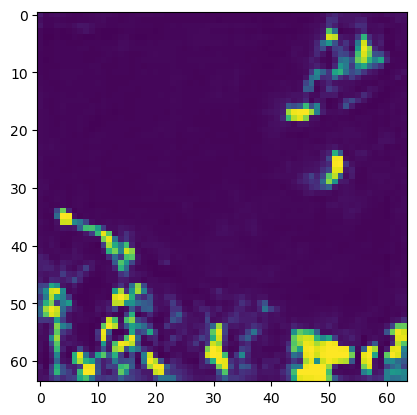

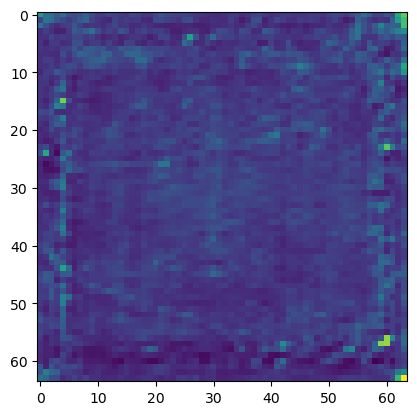

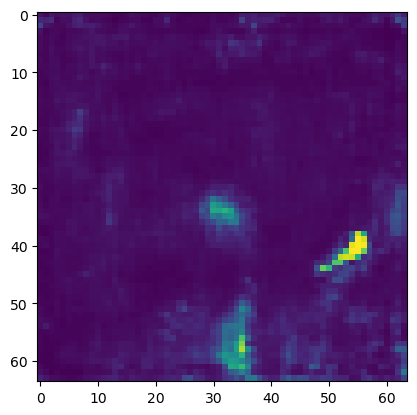

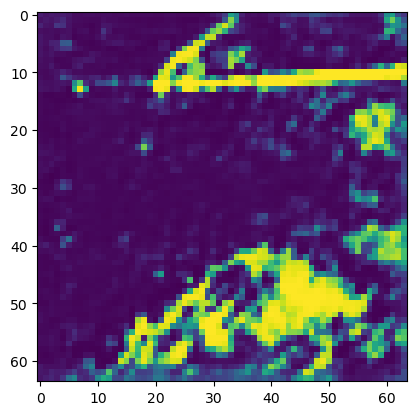

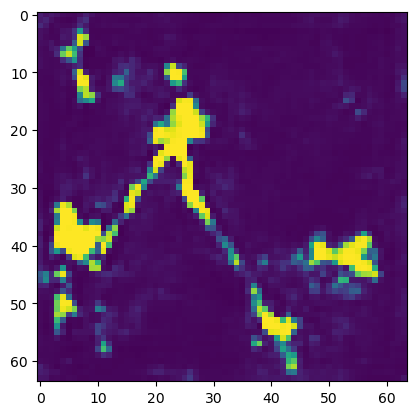

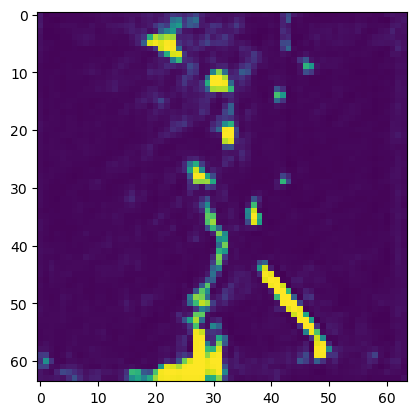

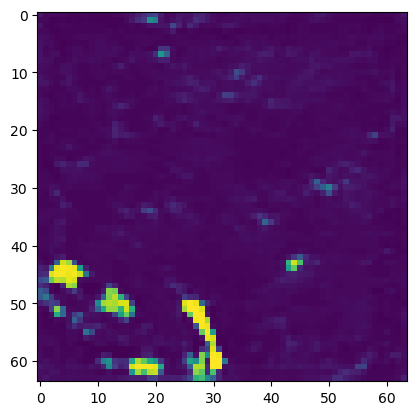

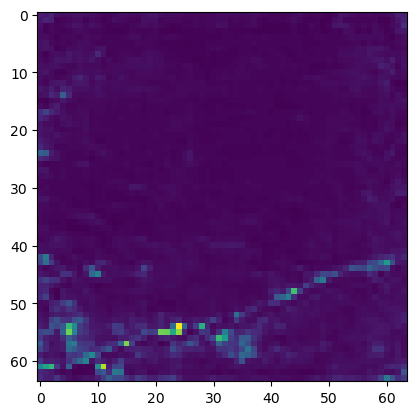

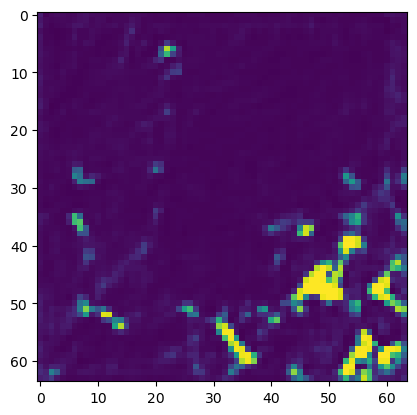

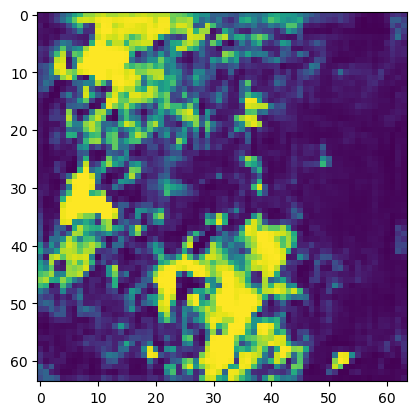

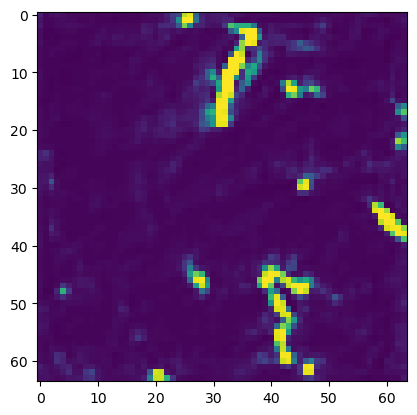

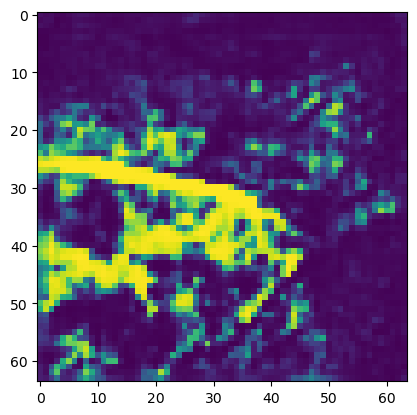

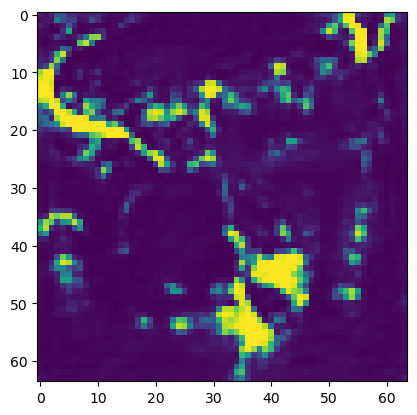

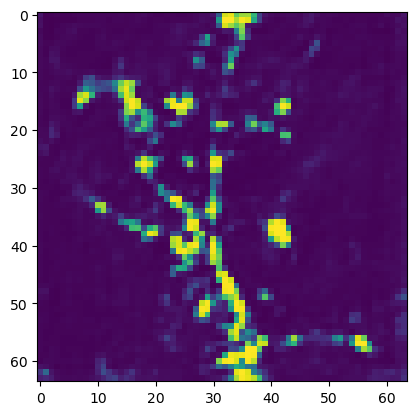

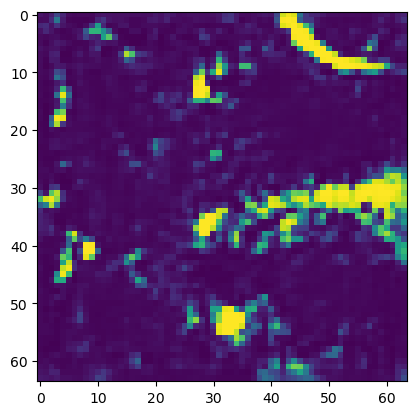

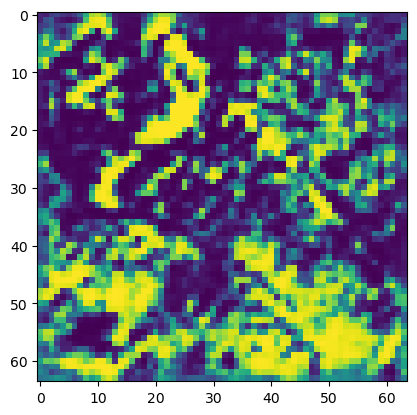

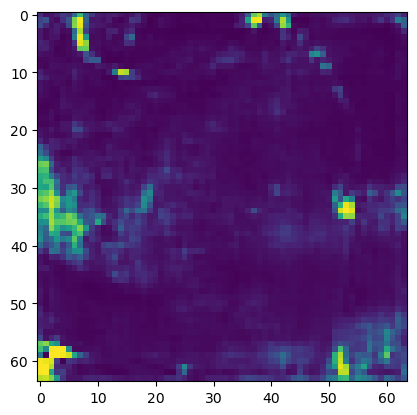

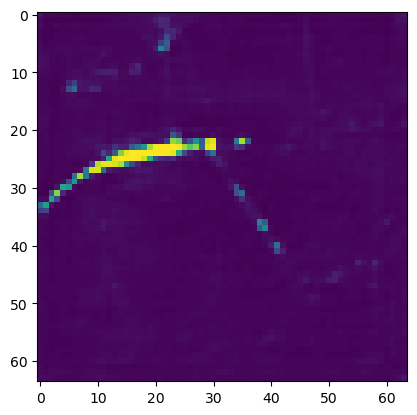

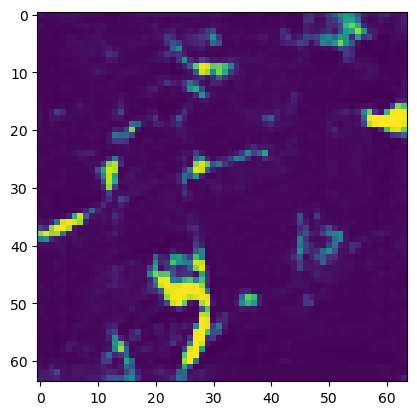

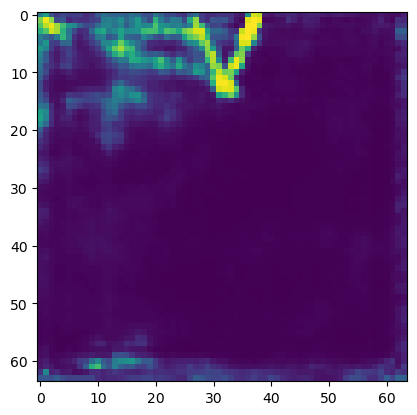

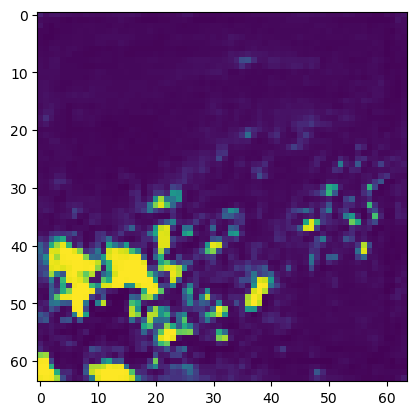

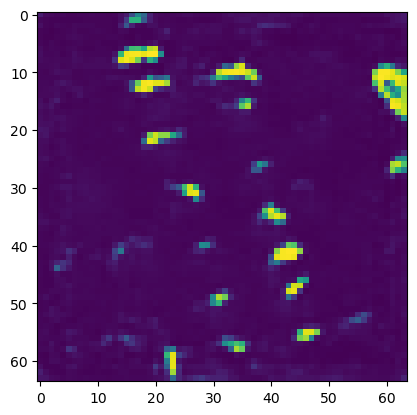

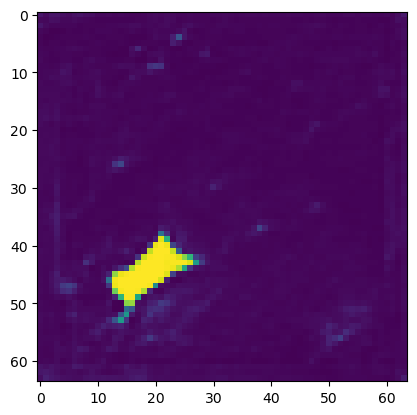

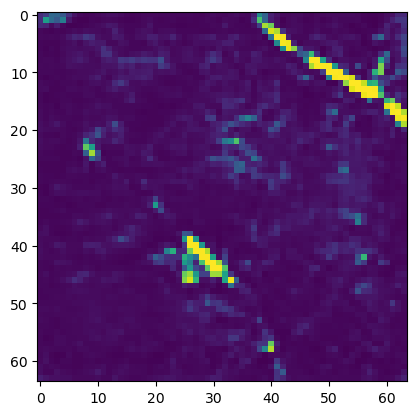

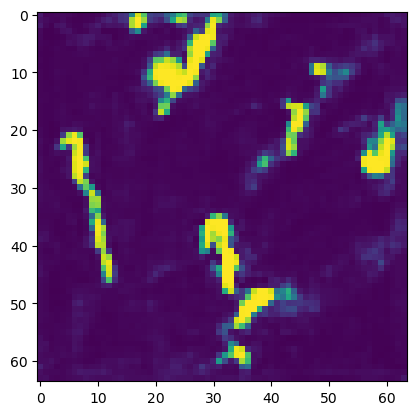

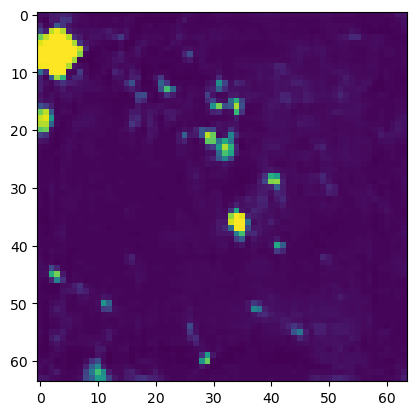

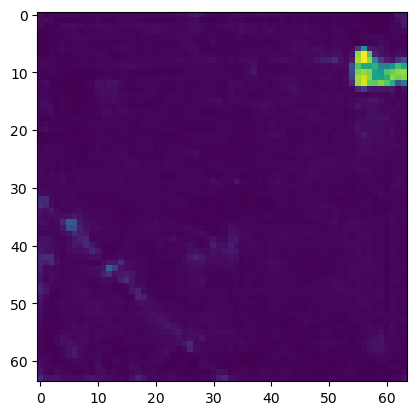

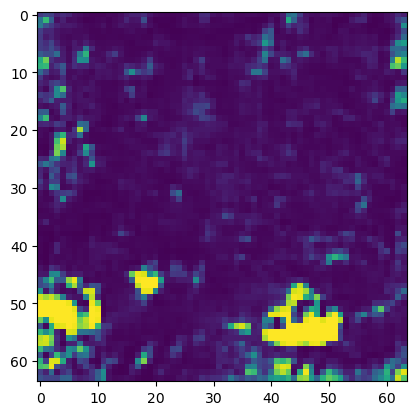

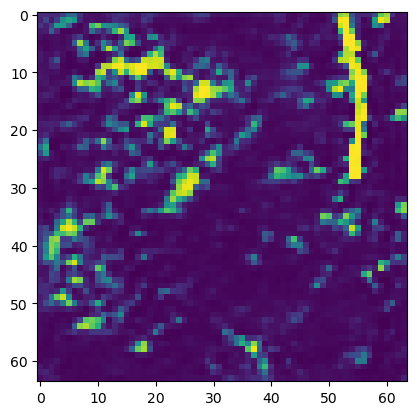

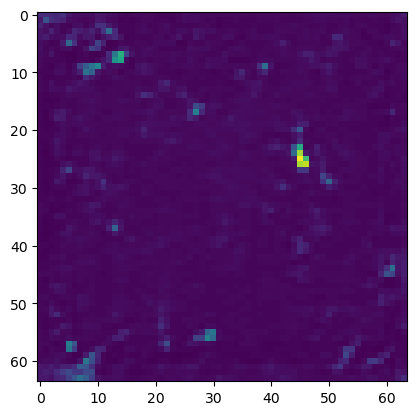

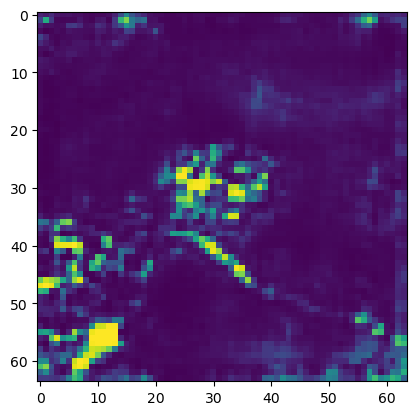

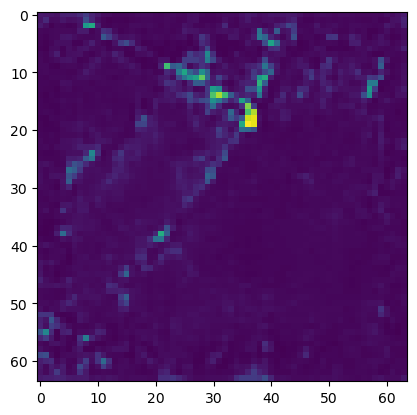

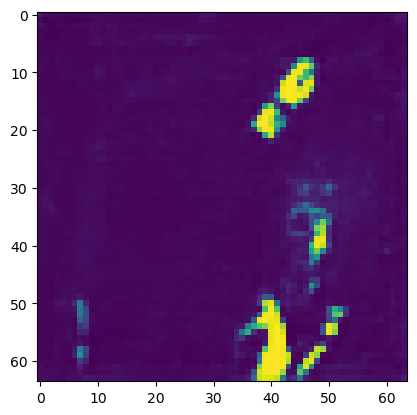

In [52]:
for i in range(test_predict.shape[0]):
    plt.imshow(test_predict[i])
    plt.show()

In [53]:
for i in range(test_predict.shape[0]):
    for j in range(test_predict.shape[1]):
        for k in range(test_predict.shape[2]):
            if(test_predict[i][j][k]<=0.5):
                test_predict[i][j][k]=0.
            else:
                test_predict[i][j][k]=1.

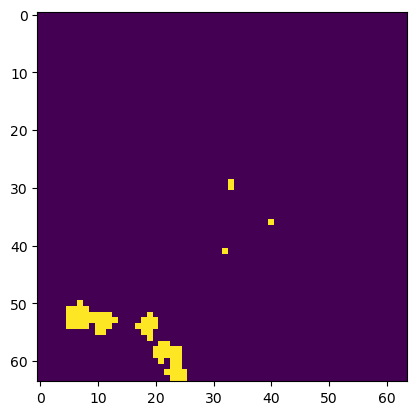

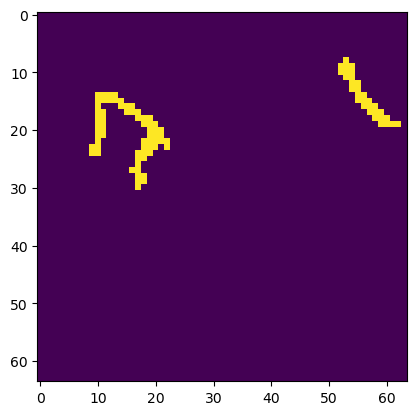

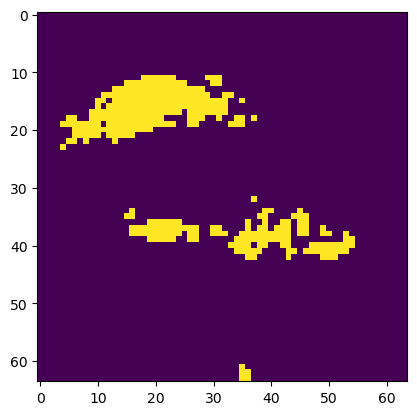

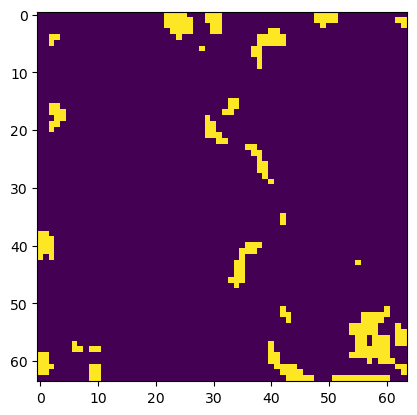

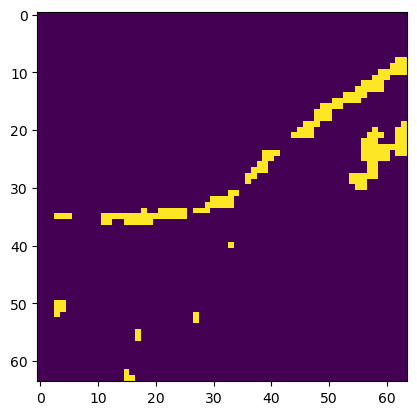

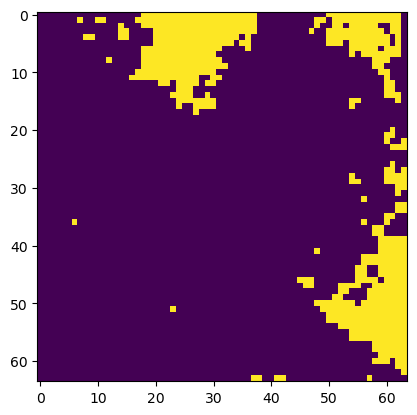

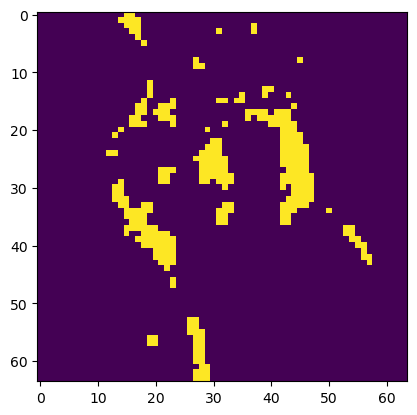

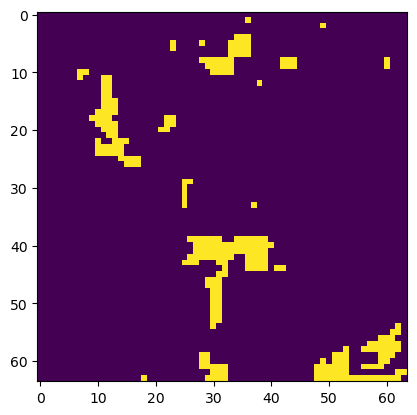

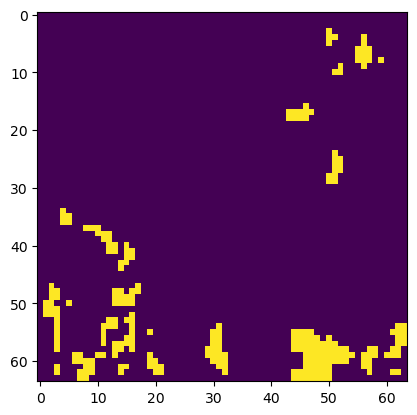

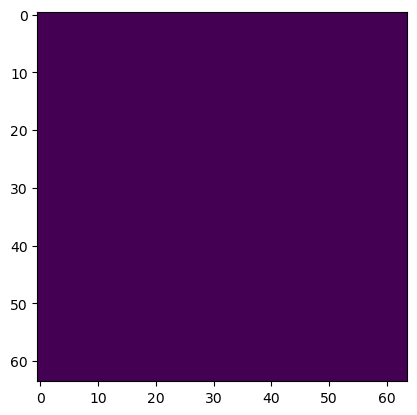

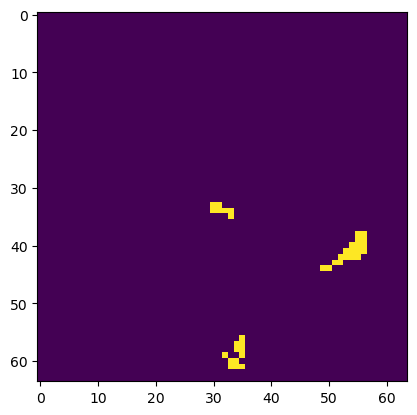

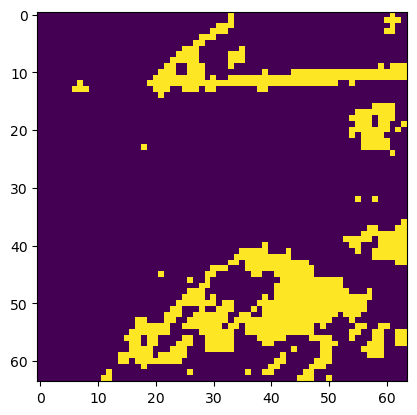

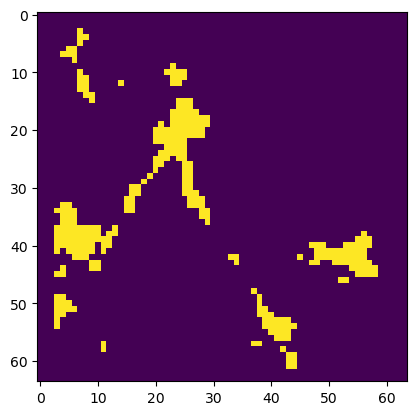

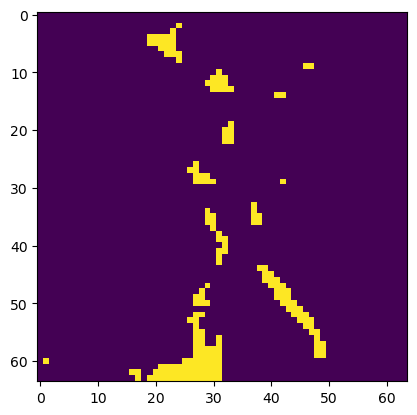

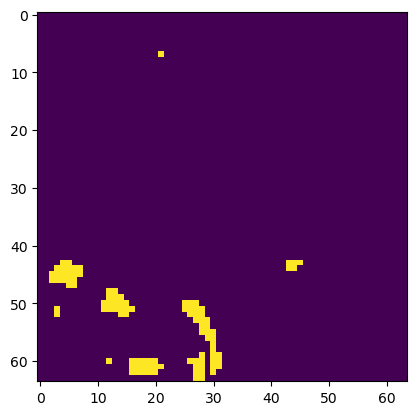

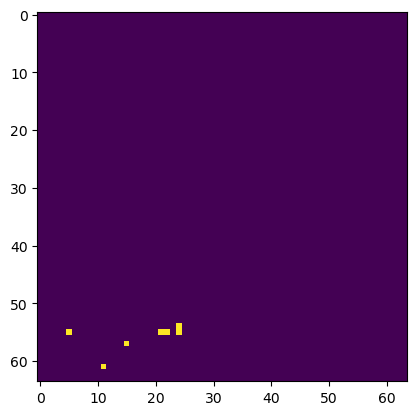

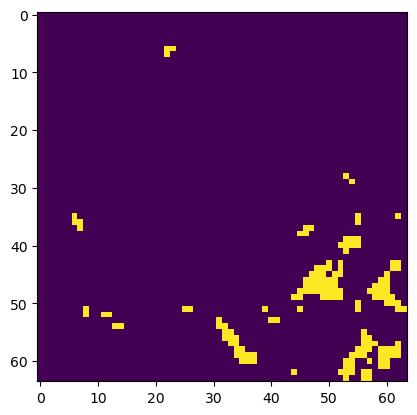

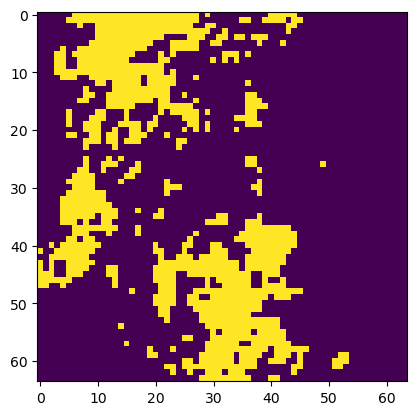

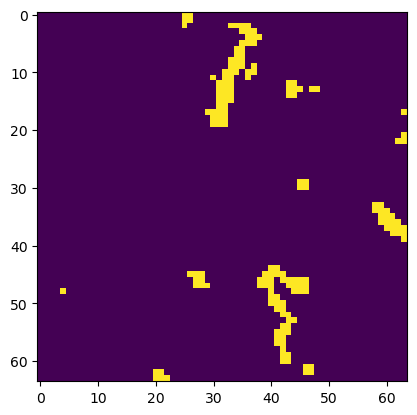

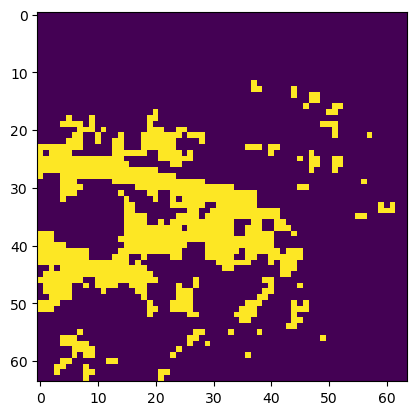

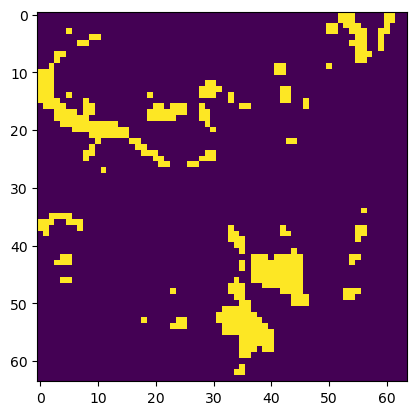

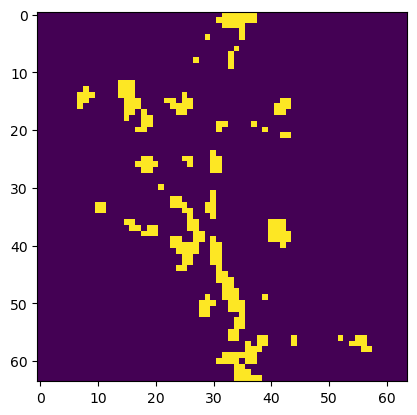

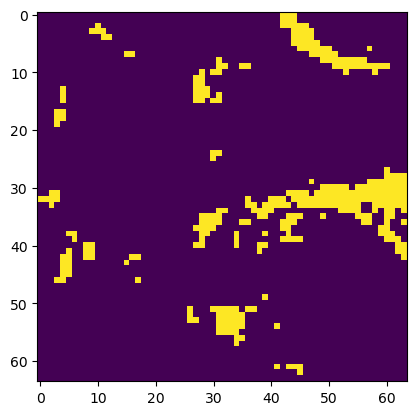

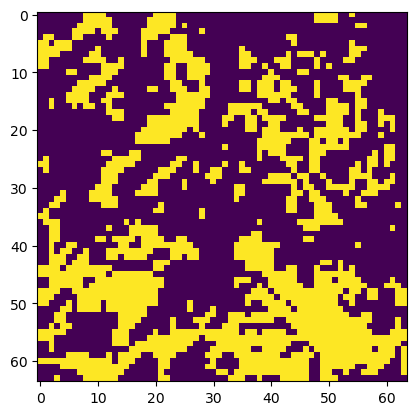

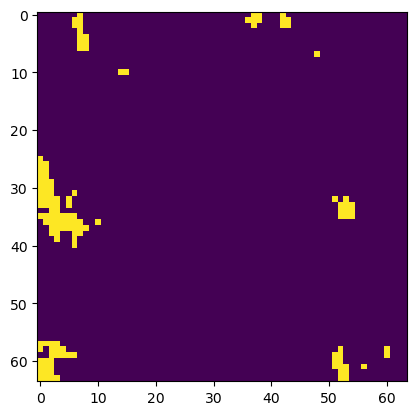

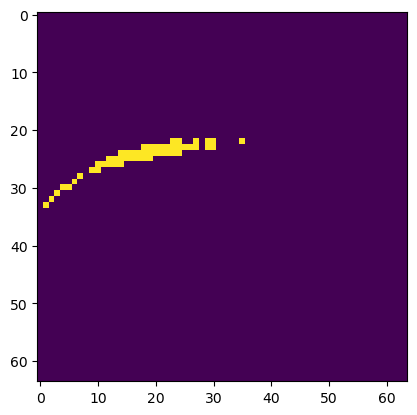

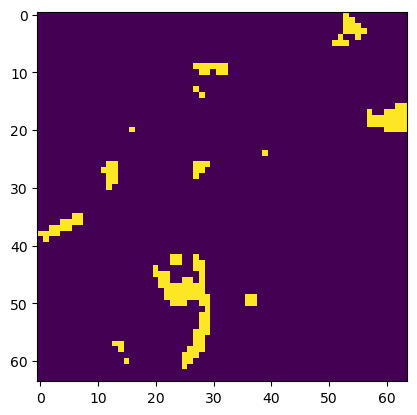

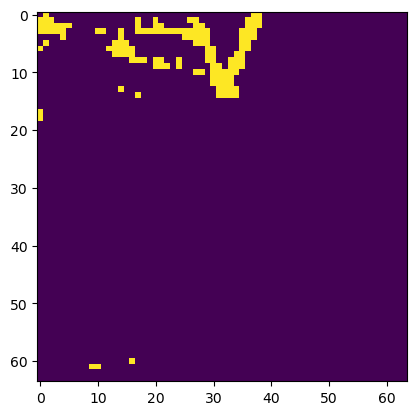

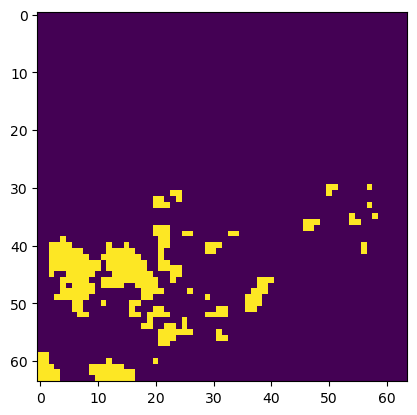

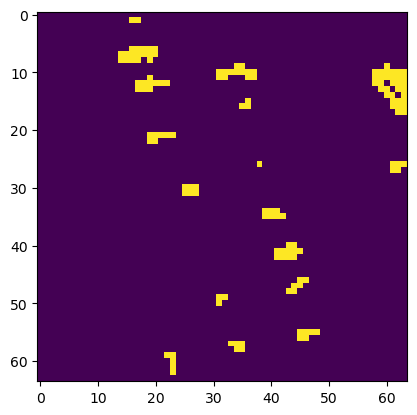

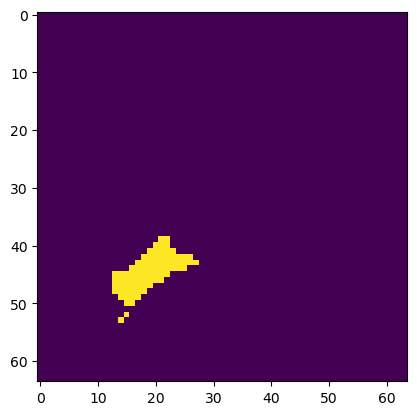

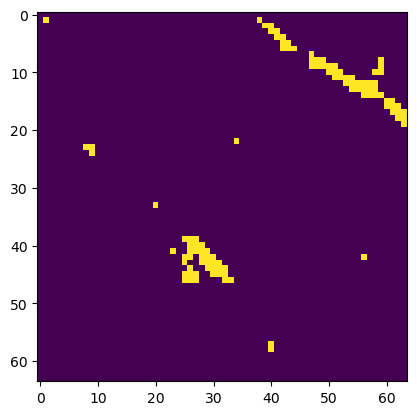

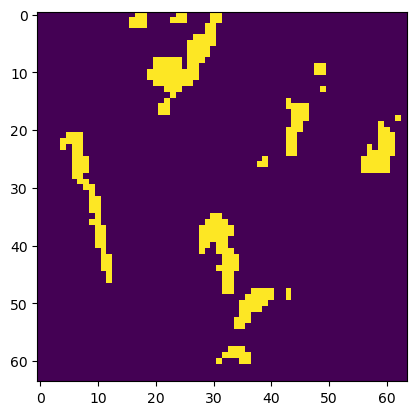

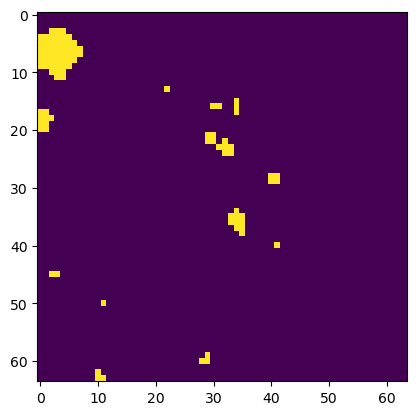

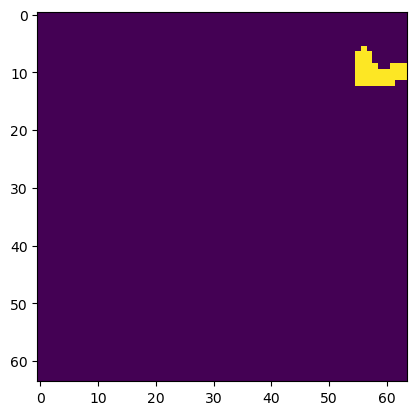

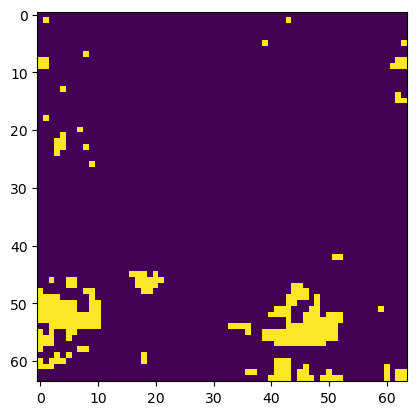

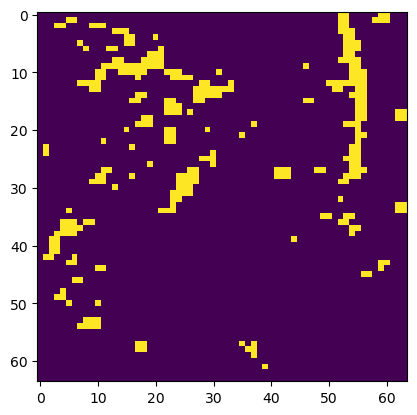

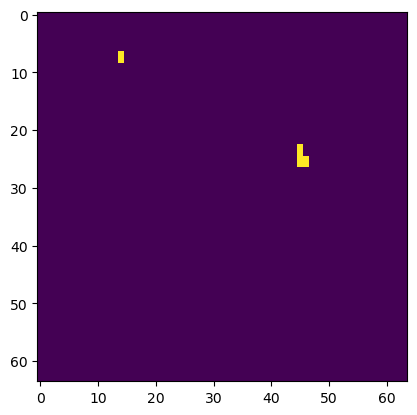

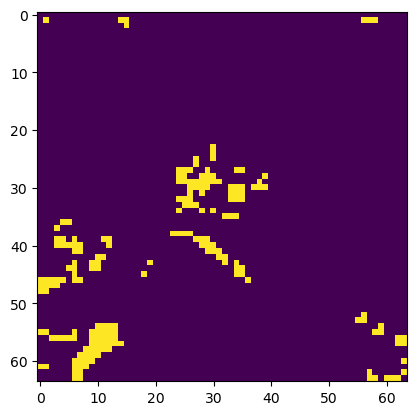

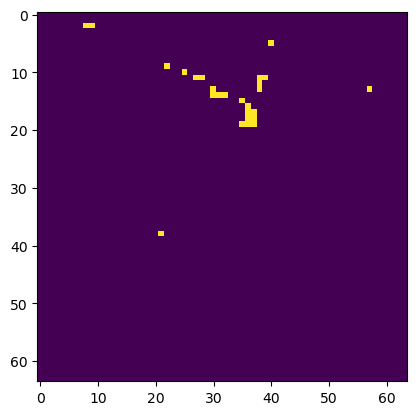

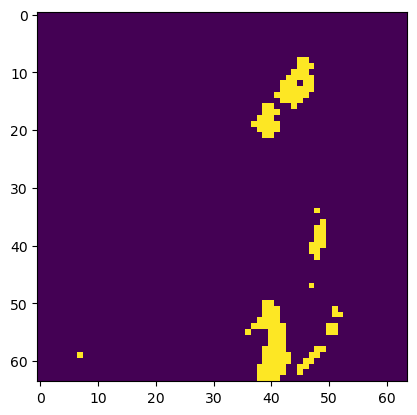

In [54]:
for i in range(test_predict.shape[0]):
    plt.imshow(test_predict[i])
    plt.show()

In [61]:
test_x2=sorted(glob(os.path.join(dataset_path,"test2","images","*")))

In [62]:
test_data_x2=np.zeros((len(test_x2),width,height,3),dtype='float')

In [63]:
for i in range(len(test_x2)):
    test_data_x2[i]=read_image(test_x2[i])

In [64]:
test_predict2=model.predict(test_data_x2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


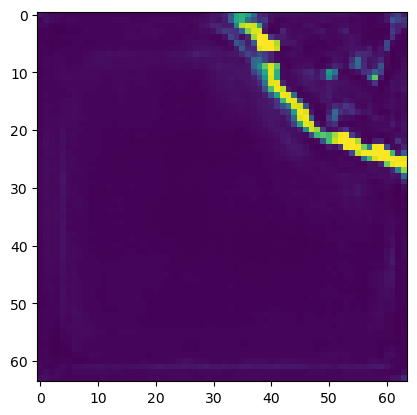

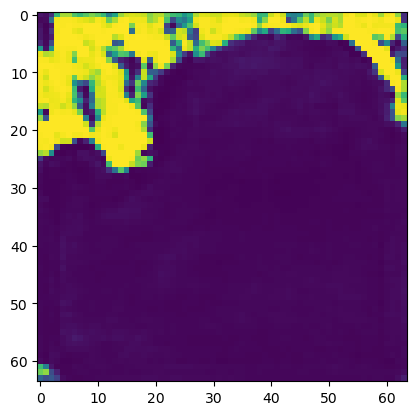

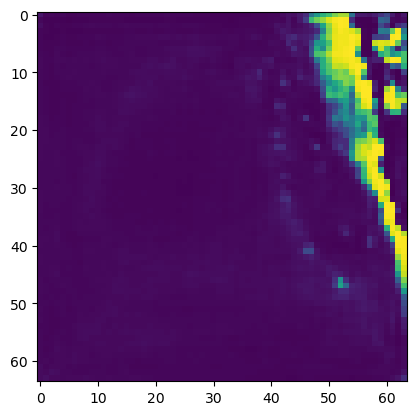

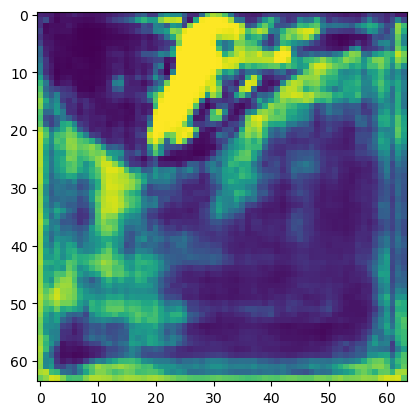

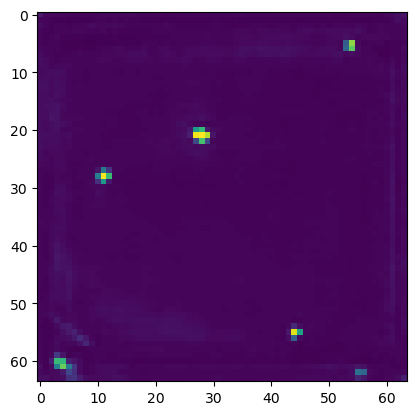

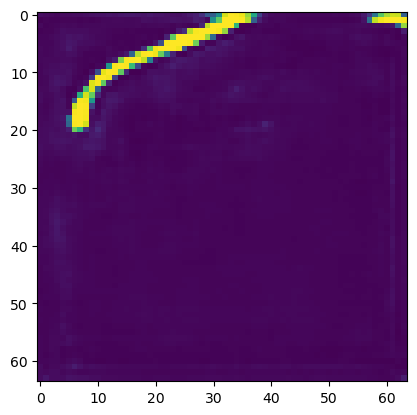

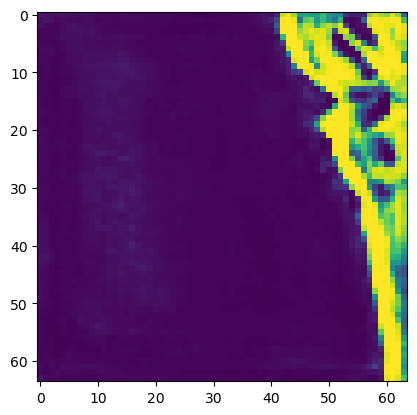

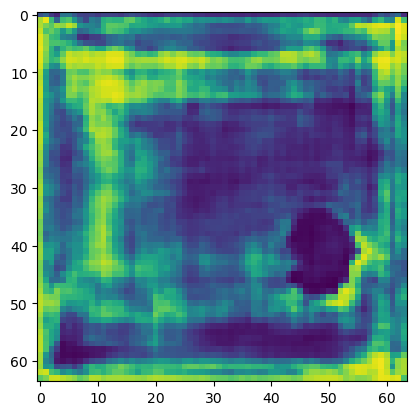

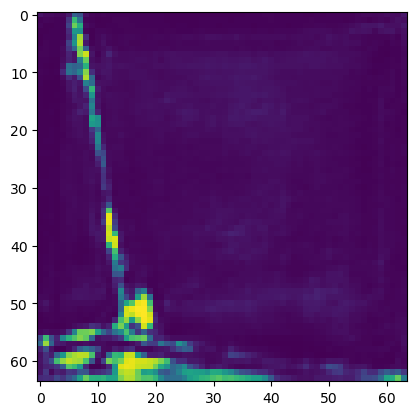

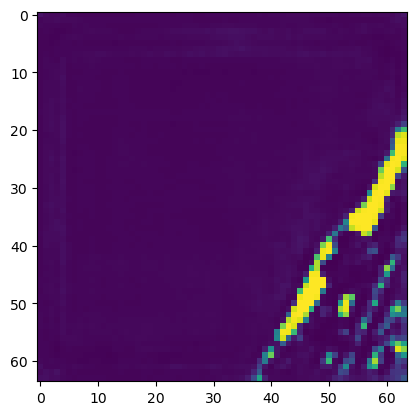

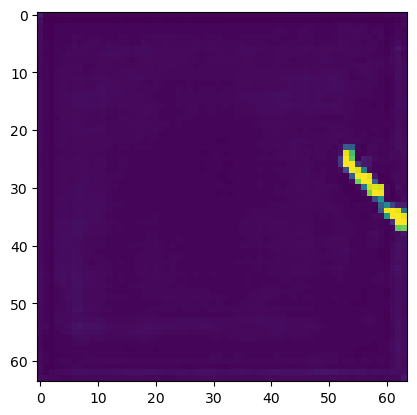

In [65]:
for i in range(test_predict2.shape[0]):
    plt.imshow(test_predict2[i])
    plt.show()

In [66]:
for i in range(test_predict2.shape[0]):
    for j in range(test_predict2.shape[1]):
        for k in range(test_predict2.shape[2]):
            if(test_predict2[i][j][k]<=0.5):
                test_predict2[i][j][k]=0.
            else:
                test_predict2[i][j][k]=1.

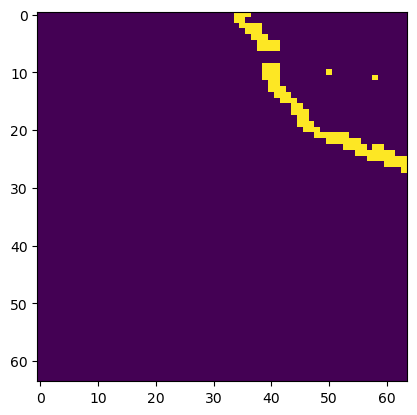

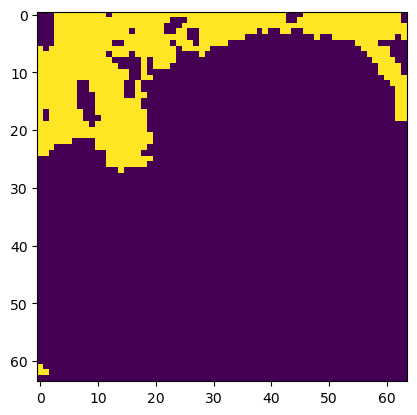

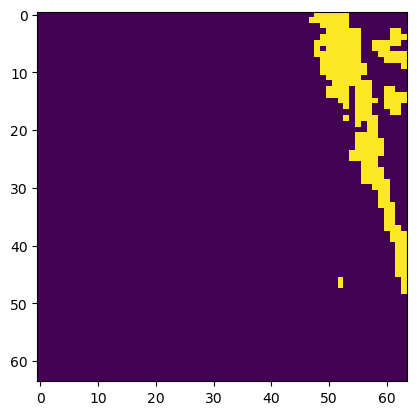

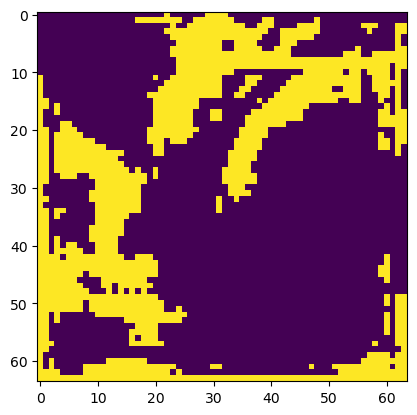

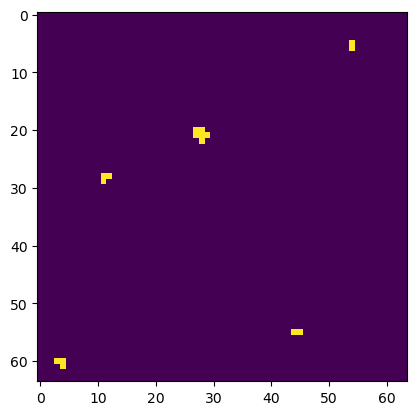

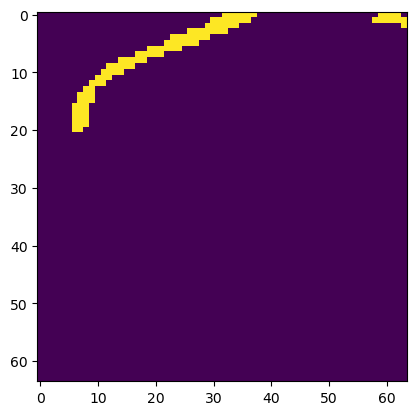

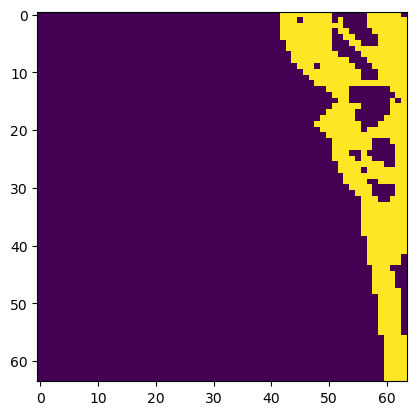

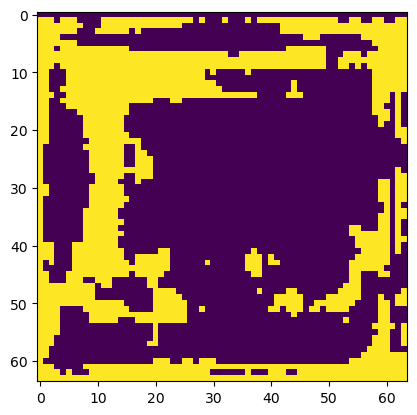

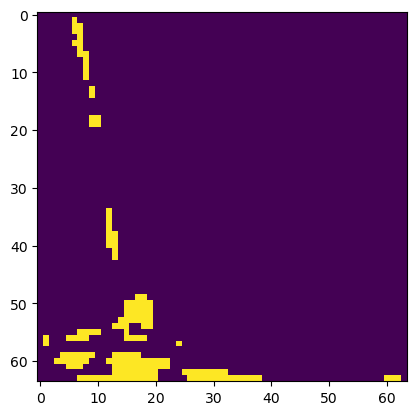

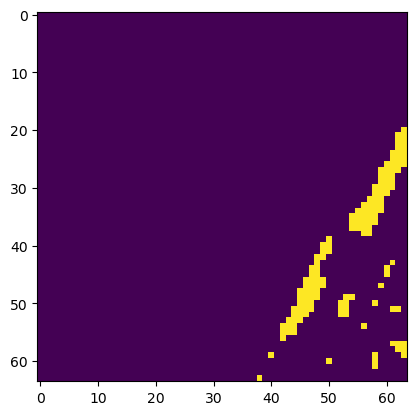

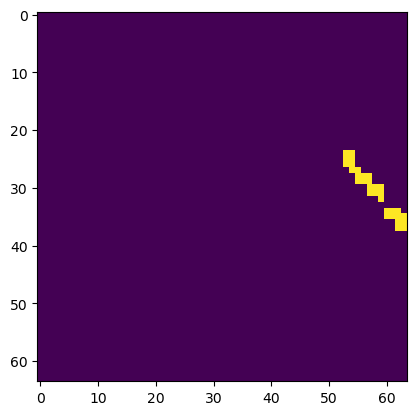

In [67]:
for i in range(test_predict2.shape[0]):
    plt.imshow(test_predict2[i])
    plt.show()